# 환경세팅



In [ ]:
# 1단계 (다운완료)
!apt install fonts-nanum
!ls /usr/share/fonts/truetype/nanum/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (13.9 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 155673 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumBarunGothicBold.ttf  NanumMyeongjoBold.ttf  NanumSquareRoundR.ttf
NanumBarunGothic

In [ ]:
# 2단계
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font = fm.FontProperties(fname=font_path, size=9)
fm._rebuild()

In [ ]:
# 3단계 (수동으로 런타임 재시작을 안 해도 됨, 실행버튼은 다시 눌러야 함.)
import os
os.kill(os.getpid(), 9)

In [ ]:
# 4단계 (최종설정)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
import seaborn as sns

font_path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=font_path, size=9).get_name()

# sns 설정
sns.set(font=font_name, 
        rc={"axes.unicode_minus":False,
            'figure.figsize': (10,6)},    
        style='darkgrid')
fm._rebuild()

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.cluster import KMeans
import os
pd.plotting.register_matplotlib_converters()

In [ ]:
base_path

# demo: 고객 데모 정보

In [ ]:
df_demo = pd.read_csv(os.path.join(base_path, file_path_dic['demo']))

# 상품 구매 정보: 유통사 상품 구매 내역

In [ ]:
df_pdde_raw = pd.read_csv(os.path.join(base_path, file_path_dic['pdde']), dtype={'br_c':str, 'de_dt':str, 'de_hr':str, 'buy_am':np.int64})

In [ ]:
df_pdde_raw['de_dthr'] = df_pdde_raw.de_dt + df_pdde_raw.de_hr
df_pdde_raw.de_dthr = pd.to_datetime(df_pdde_raw.de_dthr.astype(str), format='%Y%m%d%H')

In [ ]:
df_pdde_raw.drop(labels=['de_dt','de_hr'], axis=1, inplace=True)

In [ ]:
df_pdde_raw['cust_uniq_rct_nos'] = df_pdde_raw.groupby('cust').rct_no.transform('nunique')
df_pdde_raw['cust_total_payments'] = df_pdde_raw.groupby('cust').buy_am.transform('sum')
df_pdde_raw['rct_no_uniq_pd_cs'] = df_pdde_raw.groupby(['rct_no']).pd_c.transform('nunique')
df_pdde_raw['rct_no_pd_cs'] = df_pdde_raw.groupby(['rct_no']).pd_c.transform('count')
df_pdde_raw['rct_no_payment'] = df_pdde_raw.groupby(['rct_no']).buy_am.transform('sum')

# RFM 세그먼트
1. RFM 각 점수별 기준 설정
2. 각 점수별 비율 설정
3. 고객 세분화 기반 매트릭스 분석

## 마진 설정

In [ ]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.00)    
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

## RFM

In [ ]:
# 장바구니별로 groupby
df_crm = (df_pdde_raw.groupby(['rct_no'])
         .agg({'cust':'first', 'de_dthr':'first', 'rct_no_payment':'first'}) # cust_uniq_rct_nos':'first'
         .sort_values(by='de_dthr', ascending=True)
         .reset_index() # drop=True
         .rename(columns={'rct_no_payment':'buy_am'})   # 'cust_uniq_rct_nos':'rct_cnt'
)

,rct_no,cust,de_dthr,buy_am
0,E02000052541,M978764630,2021-01-01 00:00:00,444800
1,E02000057891,M601576068,2021-01-01 00:00:00,40290
2,E02000056622,M726383544,2021-01-01 00:00:00,41230
3,E02000055173,M102283139,2021-01-01 00:00:00,9360
4,E02000054678,M564299660,2021-01-01 00:00:00,30500
...,...,...,...,...
1266584,A04128987327,M562823758,2021-12-31 23:00:00,9000
1266585,A04128847016,M326961541,2021-12-31 23:00:00,31150
1266586,A04128958050,M629230802,2021-12-31 23:00:00,2000
1266587,E03012401343,M655525572,2021-12-31 23:00:00,60080


## 상반기 하반기 데이터 나누기

- 상반기 하반기 모두 구매한 고객은 22,767명
- 상반기만 구매한 고객은 2,249명
- 하반기만 구매한 고객은 1,901명
- 상반기에만 구매하고 하반기에는 이탈한 비율은 약 8.3퍼센트

In [ ]:
half = '2021-07-01'

# 상반기 데이터: df_first_half, 하반기 데이터: df_second_half
df_first_half = df_pdde_raw.query('de_dthr < @half ')
df_second_half = df_pdde_raw.query('de_dthr >= @half')

### 상반기

In [ ]:
# 상반기 장바구니별로 groupby
df_crm_first = (df_first_half.groupby(['rct_no'])
         .agg({'cust':'first', 'de_dthr':'first', 'rct_no_payment':'first'})
         .sort_values(by='de_dthr', ascending=True)
         .reset_index()
         .rename(columns={'rct_no_payment':'buy_am'})
)

#상반기의 recency는 2021.7.1을 기준으로 함
most_recent_date =pd.Timestamp("2021-07-01")
df_crm_first = (df_crm_first.groupby(['cust'])
          .agg({'de_dthr': lambda date: (most_recent_date - date.max()).days,
                'rct_no': lambda num: num.nunique(), 'buy_am':'sum'})
          .astype({'buy_am':'int'})
)
df_crm_first.columns = ['recency', 'frequency', 'monetary']

# 5등급으로 나눔
df_crm_first["recency_score"] = pd.qcut(df_crm_first['recency'], 5, labels=[5, 4, 3, 2, 1])
df_crm_first["frequency_score"] = pd.qcut(df_crm_first['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
df_crm_first["monetary_score"] = pd.qcut(df_crm_first['monetary'], 5, labels=[1, 2, 3, 4, 5])

#datatype 형변환
df_crm_first[['recency_score','frequency_score','monetary_score']] = df_crm_first[['recency_score','frequency_score','monetary_score']].astype(int)

df_crm_first['rfm_score'] = ((0.3*df_crm_first['recency_score'] + 0.2*df_crm_first['frequency_score'] + 0.5*df_crm_first['monetary_score']) * 100 / 5).astype(int)

#기타:0-39점, 일반:40-59점, 우수:60-79점, 최우수:80-100점
df_crm_first["rfm_level"] = pd.cut(df_crm_first["rfm_score"], bins=4, right=False, labels=['기타고객','일반고객','우수고객','최우수고객'])

In [ ]:
#비활동:0-20점, 기타:20-39점, 일반:40-59점, 우수:60-79점, 최우수:80-100점
bins = [0, 20, 40, 60, 80, 100]
df_crm_first["rfm_level"] = pd.cut(df_crm_first["rfm_score"], bins, right=False, labels=['비활동고객','기타고객','일반고객','우수고객','최우수고객'])

### 하반기

In [ ]:
# 하반기 장바구니별로 groupby
df_crm_second = (df_second_half.groupby(['rct_no'])
         .agg({'cust':'first', 'de_dthr':'first', 'rct_no_payment':'first'})
         .sort_values(by='de_dthr', ascending=True)
         .reset_index()
         .rename(columns={'rct_no_payment':'buy_am'})
)

# 하반기의 recency는 2022.1.1을 기준으로 함
most_recent_date =pd.Timestamp("2022-01-01")
df_crm_second = (df_crm_second.groupby(['cust'])
          .agg({'de_dthr': lambda date: (most_recent_date - date.max()).days,
                'rct_no': lambda num: num.nunique(), 'buy_am':'sum'})
          .astype({'buy_am':'int'})
)
df_crm_second.columns = ['recency', 'frequency', 'monetary']
#          .reset_index()

# 5등급으로 나눔
df_crm_second["recency_score"] = pd.qcut(df_crm_second['recency'], 5, labels=[5, 4, 3, 2, 1])
df_crm_second["frequency_score"] = pd.qcut(df_crm_second['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
df_crm_second["monetary_score"] = pd.qcut(df_crm_second['monetary'], 5, labels=[1, 2, 3, 4, 5])

#datatype 형변환
df_crm_second[['recency_score','frequency_score','monetary_score']] = df_crm_second[['recency_score','frequency_score','monetary_score']].astype(int)

df_crm_second['rfm_score'] = ((0.3*df_crm_second['recency_score'] + 0.2*df_crm_second['frequency_score'] + 0.5*df_crm_second['monetary_score']) * 100 / 5).astype(int)

#기타:0-39점, 일반:40-59점, 우수:60-79점, 최우수:80-100점
df_crm_second["rfm_level"] = pd.cut(df_crm_second["rfm_score"], bins=4, right=False, labels=['기타고객','일반고객','우수고객','최우수고객'])

- 구매 금액 평균: 80,303원
- 50% 금액: 20,200원
- 최소 구매 금액: 10원
- 최대 구매 금액: 64,000,000원

> 대부분 5만원 이하에 분포하고 소수의 높은 지출때문에 평균이 올라감. 

In [ ]:
df_crm.buy_am.describe([0.01,0.25,0.50,0.75,0.99])

count    1.266589e+06
mean     8.030338e+04
std      4.587786e+05
min      1.000000e+01
1%       1.000000e+03
25%      8.300000e+03
50%      2.020000e+04
75%      5.400000e+04
99%      1.041296e+06
max      6.400000e+07
Name: buy_am, dtype: float64

recency 평균이 53일, 중간값 19일

In [ ]:
df_rfm['recency'].describe()

count    26917.000000
mean        47.640227
std         76.174169
min          0.000000
25%          3.000000
50%         13.000000
75%         53.000000
max        364.000000
Name: recency, dtype: float64

In [ ]:
df_rfm['rfm_score'] = (0.3*df_rfm['recency_score'] + 0.2*df_rfm['frequency_score'] + 0.5*df_rfm['monetary_score']) * 100 / 5
df_rfm['rfm_score'].astype(int)

cust
M000034966     52
M000136117     96
M000201112     26
M000225114     80
M000261625     78
             ... 
M999599111     45
M999673157     66
M999770689     80
M999849895     54
M999962961    100
Name: rfm_score, Length: 26917, dtype: int64

0-20점은 분포가 없음. 0~40으로 합쳐도 될듯함

In [ ]:
df_rfm.groupby(['rfm_level'])[['recency',	'frequency',	'monetary']].mean()

,recency,frequency,monetary
rfm_level,,,
0이상 20미만,NaN,NaN,NaN
20이상 40미만,137.732099,6.675110,2.311392e+05
40이상 60미만,41.448664,24.259897,9.564659e+05
60이상 80미만,20.019287,44.133194,2.795643e+06
80이상 100미만,5.614955,86.778826,8.287201e+06


In [ ]:
df_rfm.loc[df_rfm['rfm_score'] == 100, 'rfm_level'] = '80이상 100미만'
df_rfm.groupby(['rfm_level'])[['recency',	'frequency',	'monetary']].count()

,recency,frequency,monetary
rfm_level,,,
0이상 20미만,0,0,0
20이상 40미만,6159,6159,6159
40이상 60미만,6214,6214,6214
60이상 80미만,7155,7155,7155
80이상 100미만,7389,7389,7389


rfm score가 만점인 고객은 1665명
- 0이상 40미만: 기타
- 40이상 60미만: 일반
- 60이상 80미만: 우수
- 80이상 100미만: 최우수

|고객 등급|고객 수|
|-|-|
|기타 |6159명|
|일반 | 6214명 |
|우수|	7155명 |
|최우수 |	7389명 |

In [ ]:
half = '2021-06-30'

# 상반기 데이터: df_first_half, 하반기 데이터: df_second_half
df_first_half = df_pdde_raw.query('de_dthr <= @half ')
df_second_half = df_pdde_raw.query('de_dthr > @half')

In [ ]:
df_first = df_crm_date[(df_crm_date.min_date <= dt_datetime) & (df_crm_date.max_date <= dt_datetime)]
df_second = df_crm_date[(df_crm_date.min_date > dt_datetime) & (df_crm_date.max_date > dt_datetime)]
df_both = df_crm_date[(df_crm_date.min_date <= dt_datetime) & (df_crm_date.max_date > dt_datetime)]

### 상반기와 하반기 고객 세그먼트

In [ ]:
df_crm_second.drop(labels='cust', axis=1)
df_join = pd.merge(df_crm_first, df_crm_second, left_index=True, right_index=True, how='outer')
df_join[['rfm_level_x','rfm_level_y']] = df_join[['rfm_level_x','rfm_level_y']].fillna('비활동고객')
df_rank = df_join[['rfm_level_x','rfm_level_y']].rename(columns={'rfm_level_x':'상반기등급', 'rfm_level_y':'하반기등급'})

In [ ]:
# df_rank: 각 고객의 상반기 등급과 하반기 등급을 나타냄
df_rank

,상반기등급,하반기등급
cust,,
M000034966,일반고객,일반고객
M000136117,최우수고객,최우수고객
M000201112,비활동고객,기타고객
M000225114,일반고객,최우수고객
M000261625,우수고객,우수고객
...,...,...
M999599111,우수고객,기타고객
M999673157,기타고객,우수고객
M999770689,우수고객,최우수고객


In [ ]:
# df_rank_clean: 상반기 등급에서 하반기 등급으로 어떻게 변했는지를 보여줌
df_rank_clean = df_rank.groupby(['상반기등급','하반기등급'])['하반기등급'].agg('count')
pd.DataFrame(df_rank_clean)

하반기등급
상반기등급 하반기등급       
비활동고객 비활동고객      0
      기타고객    1198
      일반고객     346
      우수고객     216
      최우수고객    141
기타고객  비활동고객   1626
      기타고객    2005
      일반고객    1173
      우수고객     648
      최우수고객    202
일반고객  비활동고객    395
      기타고객    1382
      일반고객    2032
      우수고객    1697
      최우수고객    549
우수고객  비활동고객    181
      기타고객     865
      일반고객    1659
      우수고객    2342
      최우수고객   1618
최우수고객 비활동고객     47
      기타고객     206
      일반고객     541
      우수고객    1459
      최우수고객   4389

비활동고객: 이탈한 고객
기타, 일반, 우수, 최우수 순서대로 이탈률이 높음.

신규 고객: 1901명

In [ ]:
rank_size = df_rank.pivot_table(index='상반기등급',columns='하반기등급', aggfunc="size")
rank_size

하반기등급,비활동고객,기타고객,일반고객,우수고객,최우수고객
상반기등급,,,,,
비활동고객,0,1198,346,216,141
기타고객,1626,2005,1173,648,202
일반고객,395,1382,2032,1697,549
우수고객,181,865,1659,2342,1618
최우수고객,47,206,541,1459,4389


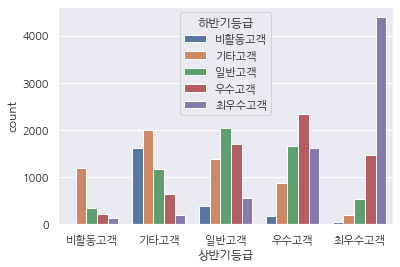

In [ ]:
sns.countplot(x = '상반기등급', hue='하반기등급',data = df_rank)

> 비활동고객에서의 이탈률
- 기타 고객: 72%로 가장 많음
- 일반 고객: 18%
- 우수 고객: 8%
- 최우수 고객: 2%




1. 이탈 고객을 위한 마케팅 전략
2. 최우수 고객을 위한 마케팅 전략

## 고객 등급 변화 분석

In [ ]:
df_demo_crm_join = pd.merge(df_demo.set_index('cust'), df_rank, left_index=True, right_index=True, how='inner')
df_demo_crm_join

,ma_fem_dv,ages,zon_hlv,상반기등급,하반기등급
cust,,,,,
M000034966,여성,40대,Z07,일반고객,일반고객
M000136117,여성,30대,Z11,최우수고객,최우수고객
M000201112,여성,50대,Z17,비활동고객,기타고객
M000225114,여성,40대,Z17,일반고객,최우수고객
M000261625,여성,40대,Z17,우수고객,우수고객
...,...,...,...,...,...
M999599111,여성,40대,Z04,우수고객,기타고객
M999673157,남성,30대,Z10,기타고객,우수고객
M999770689,여성,30대,Z16,우수고객,최우수고객


In [ ]:
df_rank_ = df_demo_crm_join
df_rank_['최종등급'] = (df_rank['상반기등급'].astype(str)+"-"+df_rank['하반기등급'].astype(str))

In [ ]:
df_rank_sort = df_rank_.sort_values('최종등급')
df_rank_sort

,ma_fem_dv,ages,zon_hlv,상반기등급,하반기등급,최종등급
cust,,,,,,
M364210315,여성,50대,Z11,기타고객,기타고객,기타고객-기타고객
M628470083,남성,30대,Z15,기타고객,기타고객,기타고객-기타고객
M081033071,남성,20대,Z15,기타고객,기타고객,기타고객-기타고객
M700949123,남성,40대,Z01,기타고객,기타고객,기타고객-기타고객
M825824377,남성,30대,Z10,기타고객,기타고객,기타고객-기타고객
...,...,...,...,...,...,...
M375297527,남성,50대,Z12,최우수고객,최우수고객,최우수고객-최우수고객
M375462281,남성,60대,Z13,최우수고객,최우수고객,최우수고객-최우수고객
M375567110,여성,30대,Z17,최우수고객,최우수고객,최우수고객-최우수고객


많은 순으로 나열.

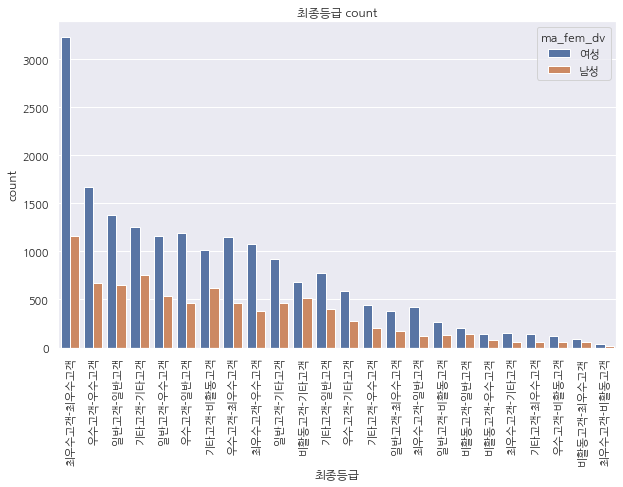

In [ ]:
plt.figure(figsize=(10,6))

ax = sns.countplot(x = '최종등급', hue="ma_fem_dv", data = df_rank_sort, order = df_rank_sort['최종등급'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_title('최종등급 count')

plt.show()